# Feature Engineering
Let's start by importing all of the libraries we will use in this notebook, then let's set up all of our SageMaker variables.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sagemaker import get_execution_role
from sagemaker import PCA

Honestly, using SageMaker for the PCA task we will complete later is overkill for this dataset and sci-kit learn's PCA would suffice in this situation. However, it is fun to use SageMaker and this helps to future proof this code if I extend the project to more geographic regions with many more samples. Maybe a popular real estate company will create a direct MLS API at some point?! A girl can dream. So we will use SageMaker.

In [2]:
# sagemaker libraries
import boto3
import sagemaker
import mxnet as mx

In [3]:
session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::359641297910:role/service-role/AmazonSageMaker-ExecutionRole-20190726T141659


In [4]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-2-359641297910



In [5]:
# define location to store model artifacts
prefix = 'listings'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-2-359641297910/listings/


In [6]:
active = pd.read_csv('cleaned_active.csv')
past = pd.read_csv('cleaned_past.csv')

In [7]:
print(active.shape)
active.head()

(373, 16)


,SALE TYPE,PROPERTY TYPE,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE
0,MLS Listing,Single Family Residential,Canyon Country,91351.0,590000.0,4.0,2.0,CAN1 - Canyon Country 1,1577.0,18386.0,1988.0,3.0,374.0,0.0,34.434697,-118.490844
1,MLS Listing,Single Family Residential,Newhall,91321.0,589000.0,3.0,2.5,NEW4 - Newhall 4,2125.0,33397.0,2014.0,34.0,277.0,193.0,34.399271,-118.484278
2,MLS Listing,Single Family Residential,Saugus,91390.0,664900.0,5.0,4.0,BOUQ - Bouquet Canyon,2461.0,6490.0,1979.0,47.0,270.0,0.0,34.461803,-118.495313
3,MLS Listing,Single Family Residential,Canyon Country,91351.0,435000.0,3.0,1.0,CAN1 - Canyon Country 1,920.0,5866.0,1961.0,1.0,473.0,0.0,34.421112,-118.468855
4,MLS Listing,Condo/Co-op,Saugus,91390.0,400000.0,2.0,2.5,COPN - Copper Hill North,1059.0,224705.0,1988.0,1.0,378.0,205.0,34.462818,-118.534228


In [8]:
print(past.shape)
past.head()

(836, 16)


,SALE TYPE,PROPERTY TYPE,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE
0,PAST SALE,Single Family Residential,Canyon Country,91387.0,570000,3.0,2.50,CAN2 - Canyon Country 2,1464.0,10789.0,1983.0,5,389.0,0.0,34.449485,-118.400176
1,PAST SALE,Single Family Residential,Canyon Country,91387.0,535000,3.0,2.00,CAN2 - Canyon Country 2,1548.0,24285.0,1974.0,69,346.0,0.0,34.457457,-118.389404
2,PAST SALE,Single Family Residential,Canyon Country,91387.0,525000,4.0,2.00,CAN2 - Canyon Country 2,1326.0,7336.0,1975.0,37,396.0,0.0,34.454962,-118.391801
3,PAST SALE,Single Family Residential,Canyon Country,91387.0,560000,4.0,2.00,CAN2 - Canyon Country 2,1854.0,6628.0,1991.0,31,302.0,0.0,34.440028,-118.388719
4,PAST SALE,Single Family Residential,Canyon Country,91387.0,560000,3.0,1.75,CAN2 - Canyon Country 2,1479.0,8662.0,1965.0,18,379.0,45.0,34.427945,-118.425415


## Visualization of Data
Now that we have cleaned the data, let's get a rough idea of the distribution of what remains.

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Price')

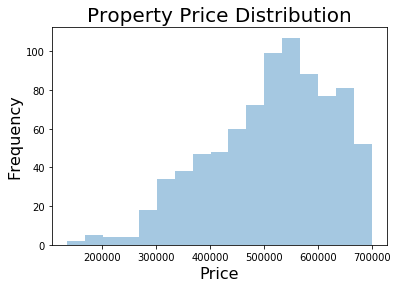

In [26]:
sns.distplot(past['PRICE'], kde=False)
plt.title('Property Price Distribution', fontsize=20)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Price', fontsize=16)

In [27]:
past['PRICE'].median()

530000.0

In [28]:
active['PRICE'].median()

559900.0

## Prepare Data
Now that we have clean data, let's prep it for our model. We need to extract the price feature to use for our target vector (y). We also want to convert all of our categorical variables to numerical values; we will use one hot encoding to accomplish this task.

In [116]:
# Concatenate active and past samples temporarily in order to keep a consistent feature set after one hot encoding
combined = pd.concat([active, past])
combined.shape

(1209, 16)

In [117]:
# Convert categorical data to numerical
cat_cols = ['SALE TYPE', 'PROPERTY TYPE', 'CITY', 'LOCATION']
combined = pd.get_dummies(combined, columns=cat_cols)
combined.shape

(1209, 107)

In [118]:
active, past = combined[:len(active)], combined[len(active):]
print("Shape of Active Samples: ", active.shape)
print("Shape of Past Samples: ", past.shape)

Shape of Active Samples:  (373, 107)
Shape of Past Samples:  (836, 107)


In [119]:
# Create target vectors
y_active = active['PRICE']
y_past = past['PRICE']

# drop price column from X features
active = active.drop('PRICE', axis=1)
past = past.drop('PRICE', axis=1)

In [120]:
active.head()

,ZIP OR POSTAL CODE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,...,LOCATION_VVER - Val Verde,LOCATION_VWES - Valencia Westridge,LOCATION_Valencia - Avanti at Westcreek,LOCATION_Valencia 1,LOCATION_Valencia Creekside,LOCATION_Valencia North,LOCATION_Valencia Northbridge,LOCATION_Valencia West Creek,LOCATION_Valencia Westridge,LOCATION_Verano at Aliento Active Adult
0,91351.0,4.0,2.0,1577.0,18386.0,1988.0,3.0,374.0,0.0,34.434697,...,0,0,0,0,0,0,0,0,0,0
1,91321.0,3.0,2.5,2125.0,33397.0,2014.0,34.0,277.0,193.0,34.399271,...,0,0,0,0,0,0,0,0,0,0
2,91390.0,5.0,4.0,2461.0,6490.0,1979.0,47.0,270.0,0.0,34.461803,...,0,0,0,0,0,0,0,0,0,0
3,91351.0,3.0,1.0,920.0,5866.0,1961.0,1.0,473.0,0.0,34.421112,...,0,0,0,0,0,0,0,0,0,0
4,91390.0,2.0,2.5,1059.0,224705.0,1988.0,1.0,378.0,205.0,34.462818,...,0,0,0,0,0,0,0,0,0,0


In [121]:
past.head()

,ZIP OR POSTAL CODE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,...,LOCATION_VVER - Val Verde,LOCATION_VWES - Valencia Westridge,LOCATION_Valencia - Avanti at Westcreek,LOCATION_Valencia 1,LOCATION_Valencia Creekside,LOCATION_Valencia North,LOCATION_Valencia Northbridge,LOCATION_Valencia West Creek,LOCATION_Valencia Westridge,LOCATION_Verano at Aliento Active Adult
0,91387.0,3.0,2.50,1464.0,10789.0,1983.0,5.0,389.0,0.0,34.449485,...,0,0,0,0,0,0,0,0,0,0
1,91387.0,3.0,2.00,1548.0,24285.0,1974.0,69.0,346.0,0.0,34.457457,...,0,0,0,0,0,0,0,0,0,0
2,91387.0,4.0,2.00,1326.0,7336.0,1975.0,37.0,396.0,0.0,34.454962,...,0,0,0,0,0,0,0,0,0,0
3,91387.0,4.0,2.00,1854.0,6628.0,1991.0,31.0,302.0,0.0,34.440028,...,0,0,0,0,0,0,0,0,0,0
4,91387.0,3.0,1.75,1479.0,8662.0,1965.0,18.0,379.0,45.0,34.427945,...,0,0,0,0,0,0,0,0,0,0


In [147]:
combined = combined.drop('PRICE', axis=1)
combined.shape

(1209, 106)

## Standardize Data + Dimensionality Reduction
Next we will standardize our data and then use Principle Component Analysis (PCA) to help reduce the number of features used in our model since the current ratio of degrees of freedom (DF) to samples is very high, which has a tendancy to lead to overfitting models during training.

In [148]:
# Standardize features
X_active = StandardScaler().fit_transform(active.astype(float))
X_past = StandardScaler().fit_transform(past.astype(float))
X = StandardScaler().fit_transform(combined.astype(float))

In [149]:
print(X)

[[-0.39739452  0.91434823 -0.69905547 ... -0.04987547 -0.02877177
  -0.02877177]
 [-1.89443433 -0.16624513  0.16028166 ... -0.04987547 -0.02877177
  -0.02877177]
 [ 1.54875723  1.9949416   2.73829305 ... -0.04987547 -0.02877177
  -0.02877177]
 ...
 [-0.24769054 -0.16624513  0.16028166 ... -0.04987547 -0.02877177
  -0.02877177]
 [-0.24769054 -0.16624513  0.16028166 ... -0.04987547 -0.02877177
  -0.02877177]
 [-0.24769054 -0.16624513  1.01961879 ... -0.04987547 -0.02877177
  -0.02877177]]


In [152]:
print(X.shape)

(1209, 106)


In [153]:
# Define PCA model
NUM_COMPONENTS = len(X[0]) - 1 # We want to keep as many components as possible for later review
print("Number of initial components: ", NUM_COMPONENTS)

pca = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path=output_path,
          num_components=NUM_COMPONENTS,
          sagemaker_session=session)

Number of initial components:  105


In [173]:
# Convert X to RecordSet format for compatibility with SageMaker's PCA model
record_set_X = pca.record_set(X)

In [174]:
%%time

# Train PCA model on the now properly formatted X_past matrix
pca.fit(record_set_X)

2019-09-04 22:41:50 Starting - Starting the training job...
2019-09-04 22:41:51 Starting - Launching requested ML instances......
2019-09-04 22:43:14 Starting - Preparing the instances for training......
2019-09-04 22:43:55 Downloading - Downloading input data...
2019-09-04 22:44:49 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[09/04/2019 22:44:52 INFO 139891874244416] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[09/04/2019 22:44:52 INFO 139891874244416] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'106', u'mini_batch_size': u'500', u'num_components': u'105'}
[09/04/201


2019-09-04 22:45:01 Uploading - Uploading generated training model
2019-09-04 22:45:01 Completed - Training job completed
Training seconds: 66
Billable seconds: 66
CPU times: user 413 ms, sys: 29.9 ms, total: 443 ms
Wall time: 3min 41s


## Analyze PCA Model Attributes

In [175]:
# Training job name is simply copied from the AWS console
training_job_name = 'pca-2019-09-04-22-41-50-509'

# Declare where AWS is saving the model by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# Download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

listings/pca-2019-09-04-22-41-50-509/output/model.tar.gz


2304

In [176]:
# Load the model's artifacts
pca_params = mx.ndarray.load('model_algo-1')
print(pca_params)

{'s': 
[           nan            nan            nan 4.60410632e-07
 1.20737423e-06 1.02423141e-02 1.36387497e-02 2.07044072e-02
 3.79135758e-02 5.46068661e-02 1.94223130e+00 3.58723426e+00
 4.86206579e+00 7.70938206e+00 9.61010265e+00 9.95517635e+00
 1.06736250e+01 1.33325911e+01 1.44369335e+01 1.80371056e+01
 1.91206074e+01 2.28370533e+01 2.45946350e+01 2.71195869e+01
 2.81144047e+01 3.00794811e+01 3.16835289e+01 3.26342621e+01
 3.37800903e+01 3.47850990e+01 3.47854004e+01 3.47857513e+01
 3.47860565e+01 3.47872772e+01 3.47881737e+01 3.47887268e+01
 3.47892914e+01 3.47894974e+01 3.47912560e+01 3.47934952e+01
 3.47948685e+01 3.47967644e+01 3.47997971e+01 3.48037987e+01
 3.48048363e+01 3.48073425e+01 3.48100929e+01 3.48127670e+01
 3.48134918e+01 3.48173027e+01 3.48181381e+01 3.48190308e+01
 3.48270226e+01 3.48314476e+01 3.48342743e+01 3.48391304e+01
 3.48441162e+01 3.48501625e+01 3.48617249e+01 3.48675728e+01
 3.48803635e+01 3.48946762e+01 3.49004250e+01 3.49060440e+01
 3.49166107e+01 3

In [177]:
# Save s = percentage of variance from the projected feature space
s = pd.DataFrame(pca_params['s'].asnumpy())

# Save v = makeup of the principal components
v = pd.DataFrame(pca_params['v'].asnumpy())

In [178]:
# Number of highest variance principal components (PCs) to investigate
num_PCs = 20

# Starting index, since highest variance components are located at the end of the rows
start_here = NUM_COMPONENTS - num_PCs

print(s.iloc[start_here:, :])

             0
85   36.674896
86   37.993313
87   38.074753
88   39.233101
89   39.681557
90   41.958923
91   42.220650
92   43.700737
93   47.811676
94   48.773788
95   49.152874
96   50.616928
97   51.294037
98   51.802616
99   52.909184
100  57.408234
101  57.930260
102  61.735729
103  63.879436
104  78.834190


In [179]:
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_here = NUM_COMPONENTS - n_top_components
    
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_here:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [182]:
# test cell
n_top_components = 85 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.9912869


## Deploy the PCA Model
Now that we have found the number of Principal Components that explains our desired amount of total variance, we can deploy our model for training.

In [183]:
%%time

pca_predictor = pca.deploy(initial_instance_count=1, 
                           instance_type='ml.t2.medium')

-------------------------------------------------------------------------------------------------------------------------!CPU times: user 650 ms, sys: 27 ms, total: 678 ms
Wall time: 10min 10s


In [184]:
# Train PCA model with numpy data matrix
train_pca = pca_predictor.predict(X)

# Confirm train_pca has the expected format of training features
print(train_pca[0])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 2.045860583166359e-06
      values: -1.1666348882499733e-06
      values: -1.022435526465415e-06
      values: 1.4983434493132108e-09
      values: 1.5645953421739023e-09
      values: 5.630259352074063e-07
      values: 3.7095404081810557e-07
      values: -2.1188825485296547e-06
      values: 3.306869587049732e-07
      values: -1.186309987133427e-06
      values: 0.0014738963218405843
      values: 0.03173735365271568
      values: -0.36334526538848877
      values: -0.041105762124061584
      values: -0.3568078279495239
      values: -0.13643617928028107
      values: 0.2584817409515381
      values: -0.2221103012561798
      values: 1.0416301488876343
      values: 0.3574158549308777
      values: 0.23159272968769073
      values: -0.17241522669792175
      values: -0.21832424402236938
      values: 0.16940122842788696
      values: 0.5478692650794983
      values: -0.7353962063789368
      values: 0.48260387

In [185]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, listings_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param listings_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    transformed_listings = pd.DataFrame()

    # for each of our new, transformed data points, append its component values to transformed_listings
    for data in train_pca:
        # get component values for each data point
        components = data.label['projection'].float32_tensor.values
        transformed_listings = transformed_listings.append([list(components)])

    # index same as listings_scaled
    transformed_listings.index = listings_scaled.index

    # keep only the top n components
    index = NUM_COMPONENTS - n_top_components
    transformed_listings = transformed_listings.iloc[:, index:]
    
    # reverse columns, component order     
    return transformed_listings.iloc[:, ::-1]

In [186]:
# specify top n
top_n = 85

# listings_scaled = pd.DataFrame(X)

# call your function and create a new dataframe
transformed_listings = create_transformed_df(train_pca, combined, n_top_components=top_n)

# print result
transformed_listings.head()

,104,103,102,101,100,99,98,97,96,95,...,29,28,27,26,25,24,23,22,21,20
0,-0.383990,2.188086,0.325750,1.335988,0.003251,-0.204843,1.428275,-1.401699,-0.134462,-0.471004,...,-0.000732,-0.101182,-0.661446,0.482604,-0.735396,0.547869,0.169401,-0.218324,-0.172415,0.231593
1,1.369588,0.018237,0.948351,-3.202843,0.500272,1.857549,1.780308,-1.859527,0.612540,-0.252534,...,-0.000137,0.173409,-0.725904,1.569119,0.470643,0.631998,0.609956,-0.262356,-0.034488,-0.233402
2,-3.951300,0.375523,-0.471736,-1.379998,0.326533,-1.055838,0.414315,-1.579257,-1.142416,-0.238487,...,-0.000833,-0.152648,-0.796099,0.477727,0.468923,-1.059683,-0.508418,0.011712,-0.571293,1.603781
3,1.496055,2.919255,0.142734,2.609945,1.167647,-0.566106,0.914542,-1.527745,-0.710405,-0.293602,...,-0.000571,-0.042684,-0.706107,0.090662,-0.905591,1.083773,0.799150,-0.261384,0.114413,-0.288909
4,0.509651,-0.767731,-0.320817,0.470610,-1.145476,-1.015600,-2.428360,-2.771265,-1.351204,0.347469,...,-0.001295,0.171488,-0.318554,-0.353788,-0.666221,0.332001,-0.734822,0.003220,-0.228598,0.806828


In [187]:
# Save
transformed_listings.shape

(1209, 85)

In [194]:
transformed_active, transformed_past = transformed_listings[:len(active)], transformed_listings[len(active):]
print("Shape of Active Samples: ", transformed_active.shape)
print("Shape of Past Samples: ", transformed_past.shape)

Shape of Active Samples:  (373, 85)
Shape of Past Samples:  (836, 85)


In [195]:
transformed_active.head()

,104,103,102,101,100,99,98,97,96,95,...,29,28,27,26,25,24,23,22,21,20
0,-0.383990,2.188086,0.325750,1.335988,0.003251,-0.204843,1.428275,-1.401699,-0.134462,-0.471004,...,-0.000732,-0.101182,-0.661446,0.482604,-0.735396,0.547869,0.169401,-0.218324,-0.172415,0.231593
1,1.369588,0.018237,0.948351,-3.202843,0.500272,1.857549,1.780308,-1.859527,0.612540,-0.252534,...,-0.000137,0.173409,-0.725904,1.569119,0.470643,0.631998,0.609956,-0.262356,-0.034488,-0.233402
2,-3.951300,0.375523,-0.471736,-1.379998,0.326533,-1.055838,0.414315,-1.579257,-1.142416,-0.238487,...,-0.000833,-0.152648,-0.796099,0.477727,0.468923,-1.059683,-0.508418,0.011712,-0.571293,1.603781
3,1.496055,2.919255,0.142734,2.609945,1.167647,-0.566106,0.914542,-1.527745,-0.710405,-0.293602,...,-0.000571,-0.042684,-0.706107,0.090662,-0.905591,1.083773,0.799150,-0.261384,0.114413,-0.288909
4,0.509651,-0.767731,-0.320817,0.470610,-1.145476,-1.015600,-2.428360,-2.771265,-1.351204,0.347469,...,-0.001295,0.171488,-0.318554,-0.353788,-0.666221,0.332001,-0.734822,0.003220,-0.228598,0.806828


In [196]:
transformed_past.head()

,104,103,102,101,100,99,98,97,96,95,...,29,28,27,26,25,24,23,22,21,20
0,-0.818375,3.408697,0.240056,1.993104,-0.653233,-0.160618,-0.290284,0.754372,0.171967,-0.003675,...,-0.001048,-0.017664,-0.154569,0.077670,-0.910630,0.770455,0.173211,-0.117439,-0.122622,0.631282
1,-0.862253,3.655905,0.327998,2.054754,-0.439575,-0.048575,-0.441619,0.680315,0.278540,-0.005924,...,-0.000946,-0.015303,-0.010034,-0.266452,0.371394,0.444565,0.313832,-0.077385,0.209810,-0.327195
2,-0.856397,3.756488,0.116754,2.163320,-0.277850,-0.204776,-0.271301,0.712407,0.141604,0.007767,...,-0.000958,-0.001718,-0.049330,-0.079142,-0.232725,0.663266,0.301571,-0.110841,0.084703,0.039595
3,-1.436549,3.568422,0.423014,1.428297,-0.991835,0.073920,0.080760,0.785621,0.427419,-0.090199,...,-0.001061,-0.003625,-0.070065,0.168928,-0.327523,0.286340,-0.135640,-0.097357,0.132369,-0.685028
4,-0.099081,3.604430,0.071807,2.280483,-0.136271,-0.033714,-0.143441,0.739840,-0.034038,-0.003269,...,-0.000931,0.032677,-0.093392,-0.036924,-0.684056,0.541267,0.165751,-0.104619,0.181542,-0.492672


We were able to reduce our feature set by over 20% using PCA. Now that we have completed this process, we can delete the endpoint we created and export our transformed DataFrame objects to CSV files to use in our estimator notebook!

In [197]:
# Delete PCA endpoint
session.delete_endpoint(pca_predictor.endpoint)

In [198]:
transformed_active = pd.concat([y_active, transformed_active], axis=1, ignore_index=True)
print(transformed_active.shape)
transformed_active.head()

(373, 86)


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,590000.0,-0.383990,2.188086,0.325750,1.335988,0.003251,-0.204843,1.428275,-1.401699,-0.134462,...,-0.000732,-0.101182,-0.661446,0.482604,-0.735396,0.547869,0.169401,-0.218324,-0.172415,0.231593
1,589000.0,1.369588,0.018237,0.948351,-3.202843,0.500272,1.857549,1.780308,-1.859527,0.612540,...,-0.000137,0.173409,-0.725904,1.569119,0.470643,0.631998,0.609956,-0.262356,-0.034488,-0.233402
2,664900.0,-3.951300,0.375523,-0.471736,-1.379998,0.326533,-1.055838,0.414315,-1.579257,-1.142416,...,-0.000833,-0.152648,-0.796099,0.477727,0.468923,-1.059683,-0.508418,0.011712,-0.571293,1.603781
3,435000.0,1.496055,2.919255,0.142734,2.609945,1.167647,-0.566106,0.914542,-1.527745,-0.710405,...,-0.000571,-0.042684,-0.706107,0.090662,-0.905591,1.083773,0.799150,-0.261384,0.114413,-0.288909
4,400000.0,0.509651,-0.767731,-0.320817,0.470610,-1.145476,-1.015600,-2.428360,-2.771265,-1.351204,...,-0.001295,0.171488,-0.318554,-0.353788,-0.666221,0.332001,-0.734822,0.003220,-0.228598,0.806828


In [199]:
transformed_past = pd.concat([y_past, transformed_past], axis=1, ignore_index=True)
print(transformed_past.shape)
transformed_past.head()

(836, 86)


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,570000.0,-0.818375,3.408697,0.240056,1.993104,-0.653233,-0.160618,-0.290284,0.754372,0.171967,...,-0.001048,-0.017664,-0.154569,0.077670,-0.910630,0.770455,0.173211,-0.117439,-0.122622,0.631282
1,535000.0,-0.862253,3.655905,0.327998,2.054754,-0.439575,-0.048575,-0.441619,0.680315,0.278540,...,-0.000946,-0.015303,-0.010034,-0.266452,0.371394,0.444565,0.313832,-0.077385,0.209810,-0.327195
2,525000.0,-0.856397,3.756488,0.116754,2.163320,-0.277850,-0.204776,-0.271301,0.712407,0.141604,...,-0.000958,-0.001718,-0.049330,-0.079142,-0.232725,0.663266,0.301571,-0.110841,0.084703,0.039595
3,560000.0,-1.436549,3.568422,0.423014,1.428297,-0.991835,0.073920,0.080760,0.785621,0.427419,...,-0.001061,-0.003625,-0.070065,0.168928,-0.327523,0.286340,-0.135640,-0.097357,0.132369,-0.685028
4,560000.0,-0.099081,3.604430,0.071807,2.280483,-0.136271,-0.033714,-0.143441,0.739840,-0.034038,...,-0.000931,0.032677,-0.093392,-0.036924,-0.684056,0.541267,0.165751,-0.104619,0.181542,-0.492672


In [200]:
transformed_active.to_csv('transformed_active.csv', index=False)
transformed_past.to_csv('transformed_past.csv', index=False)